In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import itertools

In [ ]:
def set_seed(seed: int = 42) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/CV_lab3/"

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
image_datasets = {x: torchvision.datasets.CIFAR10(
    root=folder_path + "TrainingData",
    train=x == 'train',
    download=True,
    transform=transform
) for x in ['train', 'test']}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set_size = int(len(image_datasets['train']) * 0.8)
valid_set_size = len(image_datasets['train']) - train_set_size

image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(image_datasets['train'], [train_set_size, valid_set_size])

In [ ]:
def create_dataloaders(batch_size=64):
    return {x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size,
        shuffle=True
    ) for x in ['train', 'val', 'test']}

In [ ]:
dataloaders = create_dataloaders()

In [ ]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
dataset_sizes

{'train': 40000, 'val': 10000, 'test': 10000}

In [ ]:
class_names = dataloaders['test'].dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

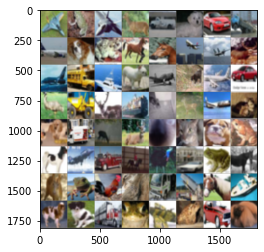

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [ ]:
class VGG16Net(nn.Module):
    def __init__(self, fully_connected_out=4096, num_classes=10):
        super(VGG16Net, self).__init__()

        self.fully_connected_out = fully_connected_out
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(25088, fully_connected_out),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(fully_connected_out, fully_connected_out),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(fully_connected_out, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
def train_model(model, criterion, optimizer, dataloaders_dict, num_epochs=10):
    y_loss = {phase: [] for phase in dataloaders_dict.keys()}
    y_acc = {phase: [] for phase in dataloaders_dict.keys()}

    best_acc = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in dataloaders_dict.keys():
                if 'train' in phase:
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)                       
                    labels_to_use = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled('train' in phase):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels_to_use)

                        if 'train' in phase:
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels_to_use)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                y_loss[phase].append(epoch_loss)
                y_acc[phase].append(epoch_acc.cpu().numpy())

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                  
    model.load_state_dict(best_model_wts)
    return model, y_loss, y_acc

In [ ]:
def draw_graphs(y_loss, y_acc, phases, num_epochs=10):
    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    ax1 = fig.add_subplot(122, title="acc")
    x_epochs = [i + 1 for i in range(num_epochs)]

    for phase in phases:
        ax0.plot(x_epochs, y_loss[phase], label=phase)
        ax1.plot(x_epochs, y_acc[phase], label=phase)
    
    ax0.legend()
    ax1.legend()

    plt.show()

In [ ]:
def visualize_acc_preds(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct = 0
    total = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            print(f'Accuracy of the network on the 10000 test images: {int(100 * correct / total)} %\n')

            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {dataloader.dataset.classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

In [ ]:
VGG16Net = VGG16Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16Net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
VGG16Net, y_loss, y_acc = train_model(VGG16Net, criterion, optimizer, dict(itertools.islice(dataloaders.items(), 0, 2)), num_epochs=5)

Epoch 1/5
----------
train Loss: 1.6720 Acc: 0.3806
val Loss: 1.3639 Acc: 0.5073
Epoch 2/5
----------
train Loss: 1.2331 Acc: 0.5562
val Loss: 1.1170 Acc: 0.6039
Epoch 3/5
----------
train Loss: 0.9536 Acc: 0.6607
val Loss: 1.0016 Acc: 0.6478
Epoch 4/5
----------
train Loss: 0.7906 Acc: 0.7239
val Loss: 0.8122 Acc: 0.7144
Epoch 5/5
----------
train Loss: 0.6825 Acc: 0.7606
val Loss: 0.7385 Acc: 0.7468


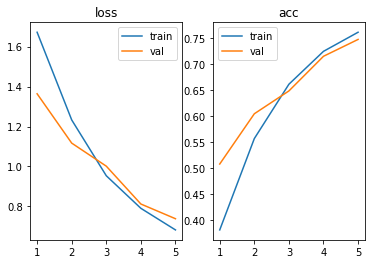

In [ ]:
draw_graphs(y_loss, y_acc, y_loss.keys(), num_epochs=5)

Accuracy of the network on the 10000 test images: 75 %



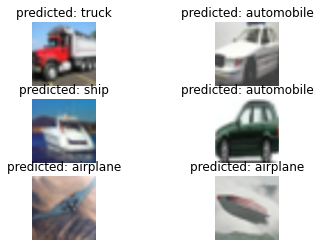

In [ ]:
visualize_acc_preds(VGG16Net, dataloaders['test'])

In [ ]:
ResNet = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet.parameters(), lr=0.01, momentum=0.9)

In [ ]:
ResNet, y_loss, y_acc = train_model(ResNet, criterion, optimizer, dict(itertools.islice(dataloaders.items(), 0, 2)), num_epochs=5)

Epoch 1/5
----------
train Loss: 1.5762 Acc: 0.4261
val Loss: 1.5297 Acc: 0.4621
Epoch 2/5
----------
train Loss: 0.9836 Acc: 0.6545
val Loss: 1.0807 Acc: 0.6446
Epoch 3/5
----------
train Loss: 0.7239 Acc: 0.7478
val Loss: 0.9923 Acc: 0.6855
Epoch 4/5
----------
train Loss: 0.5711 Acc: 0.8020
val Loss: 0.6283 Acc: 0.7850
Epoch 5/5
----------
train Loss: 0.4668 Acc: 0.8375
val Loss: 0.6436 Acc: 0.7822


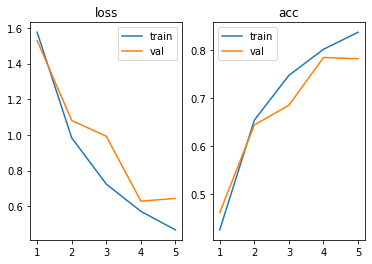

In [ ]:
draw_graphs(y_loss, y_acc, y_loss.keys(), num_epochs=5)

Accuracy of the network on the 10000 test images: 73 %



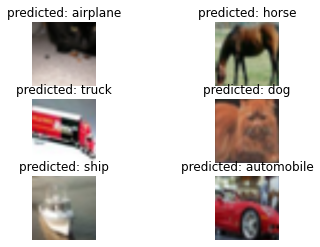

In [ ]:
visualize_acc_preds(ResNet, dataloaders['test'])